<a href="https://colab.research.google.com/github/Czyundream/note-of-dl/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#导入常用库
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

In [3]:
import pandas as pd
from torch.utils import data
#from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
!pip install -u -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1C2cnS5fi2Du6UcCbShpj1W2AaFD49huD'})
downloaded.GetContentFile('250HZ.xlsx')


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [5]:
def xlsx_to_csv():
    data_xls=pd.read_excel('250HZ.xlsx')
    data_xls.to_csv('250HZ.csv',encoding='utf-8')

xlsx_to_csv()

In [6]:
data1 = pd.read_csv('250HZ.csv')
print(data1)

      Unnamed: 0       光电           磁         温度        误差
0              0  358.375  359.331207  17.201250  0.956207
1              1  357.750  358.604736  17.242500  0.854736
2              2  357.000  357.823334  17.366249  0.823334
3              3  356.250  357.070068  17.325001  0.820068
4              4  355.500  356.318909  17.407499  0.818909
...          ...      ...         ...        ...       ...
1904        1904    1.125    1.896515  17.118750  0.771515
1905        1905    0.750    1.599884  17.283751  0.849884
1906        1906    0.500    1.349945  17.242500  0.849945
1907        1907    0.375    1.239395  17.283751  0.864395
1908        1908    0.000    0.819855  17.160000  0.819855

[1909 rows x 5 columns]


In [45]:
inputs, outputs = data1.iloc[0:1909+1, 2:4], data1.iloc[0:1909+1, 4]
features, labels = torch.tensor(inputs.values), torch.tensor(outputs.values)

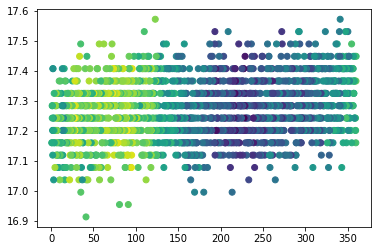

In [46]:
plt.scatter(features[:, 0], features[:, 1], c=labels)

In [47]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt

In [48]:
def load_array(data_arrays, batch_size, is_train=False):
    '''构造一个PyTorch数据迭代器'''
    dataset = data.TensorDataset(*data_arrays)#将数据转为dataset，*表示将元组拆解为一维数字作为传入参数

    #拆分训练集与预测集
    num_train = int(len(dataset)*0.8)
    num_valid = len(dataset) - num_train
    ds_train,ds_valid = data.random_split(dataset,[num_train,num_valid])

    data_train_iter, data_valid_iter = data.DataLoader(ds_train, batch_size, shuffle=is_train), data.DataLoader(ds_valid, batch_size, shuffle=is_train)
    #return data.DataLoader(dataset, batch_size, shuffle=is_train)
    #将dataset型数据挑选batch_size大小的样本，shuffle控制是否打乱
    return data_train_iter, data_valid_iter

In [49]:
def SVR_Data_precesing(pre_length, mem_data_time, features, labels):
    '''SVR数据预处理函数，归一化与构造特征向量'''
    #归一化处理
    from sklearn.preprocessing import MinMaxScaler
    scaler = preprocessing.MinMaxScaler()
    sca_X = scaler.fit_transform(features)
    New_X = torch.from_numpy(sca_X)
    #print(New_X.shape)

    #构造特征向量X
    #mem_data_time = 5

    from collections import deque
    deq = deque(maxlen=mem_data_time)

    X=[]
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_data_time:
            X.append(list(deq))

    #构造特征向量y--labels
    y = labels[mem_data_time-1:]
    print(y.shape)

    #X = np.array(New_X) 
    X = np.array(X)
    #y = np.array(labels) 
    y = np.array(y)
    #print(X.shape)
    #print(y.shape)
    return X, y
    '''
    New_X = torch.from_numpy(X).to(torch.float32)
    New_y = torch.from_numpy(y).to(torch.float32)
    '''
    # 移动到GPU上
    print("torch.cuda.is_available() = ",torch.cuda.is_available())
    New_X = New_X.cuda()
    New_y = New_y.cuda()
    print("New_X.device:",New_X.device)
    print("New_y.device:",New_y.device)
    '''
    data_train_iter, data_valid_iter = load_array((New_X, New_y), pre_length)

    #next(iter(data_iter))
    return data_train_iter, data_valid_iter
    '''

In [53]:
batch_size = 50
mem_data_time = 5
cut = 360
X, y = SVR_Data_precesing(batch_size, mem_data_time, features, labels)
X_train = X[:-cut, :]
X_test = X[-cut:, :]
y_train = y[:-cut]
y_test = y[-cut:]
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

torch.Size([1905])
X_train (1545, 5, 2)
y_train (1545,)
X_test (360, 5, 2)
y_test (360,)


In [54]:
X_train=X_train.reshape(len(X_train),10)
y_train=y_train.reshape(len(X_train))
X_test=X_test.reshape(cut,10)
y_test=y_test.reshape(cut)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1545, 10)
y_train (1545,)
X_test (360, 10)
y_test (360,)


In [55]:
from sklearn.svm import SVR  
svr = SVR(kernel='rbf', gamma=0.3) 
model = svr.fit(X_train, y_train)


In [56]:
y_train_predict=model.predict(X_train)

Text(0.5, 1.0, 'Train Data')

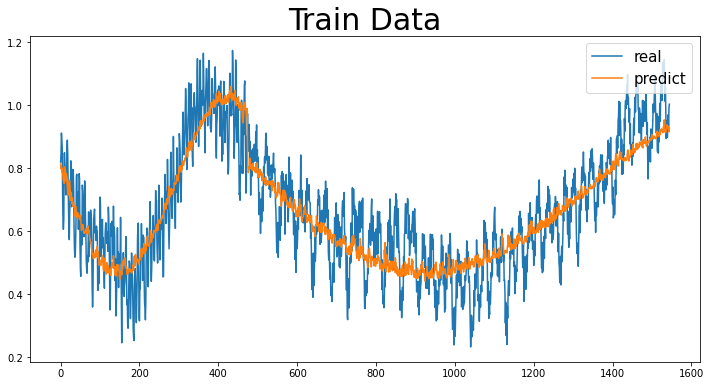

In [57]:
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[0:1600,0].plot(figsize=(12,6))
draw.iloc[0:1600,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题